In [45]:
# ! pip install gensim
# ! pip install np
# ! pip install nltp
# ! pip install enchant
# ! pip install seaborn

In [46]:
import nltk
import numpy as np
import enchant
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')      
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

[nltk_data] Downloading package punkt to /Users/mat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/mat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/mat/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mat/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to /Users/mat/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [47]:
data = []
# ścieżka do plików
p = os.path.join(os.getcwd(), 'data')
for folder in os.listdir(p):
    path = os.path.join(p, folder)
    # jeśli plik to pomiń
    if os.path.isfile(path):
        continue
    # jesli folder to pobierz pliki
    mails = os.listdir(path)
    for mail in mails:
        path = os.path.join(p, folder, mail)
        with open(path, encoding="latin-1") as file:
            text = file.read()
        data.append([text, folder])
df = pd.DataFrame(data)

In [48]:
df

,0,1
0,Newsgroups: talk.politics.mideast\nPath: canta...,talk.politics.mideast
1,Xref: cantaloupe.srv.cs.cmu.edu talk.politics....,talk.politics.mideast
2,Xref: cantaloupe.srv.cs.cmu.edu talk.politics....,talk.politics.mideast
3,Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv....,talk.politics.mideast
4,Xref: cantaloupe.srv.cs.cmu.edu soc.culture.ar...,talk.politics.mideast
...,...,...
19992,Xref: cantaloupe.srv.cs.cmu.edu talk.religion....,talk.religion.misc
19993,Xref: cantaloupe.srv.cs.cmu.edu talk.religion....,talk.religion.misc
19994,Xref: cantaloupe.srv.cs.cmu.edu sci.skeptic:43...,talk.religion.misc
19995,Xref: cantaloupe.srv.cs.cmu.edu talk.abortion:...,talk.religion.misc


In [49]:
from nltk.corpus import wordnet
# używaliśmy tego w różnych wersjach preprocesingu ostatecznie porzuciliśmy
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].lower()
    tag_dict = {"a": wordnet.ADJ,
                "n": wordnet.NOUN,
                "v": wordnet.VERB,
                "r": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [50]:
def Preprocesing(data, lematize = False, stem = True, eng = False):
    # Najlepsze wyniki były dla samego stemmingu więc jest ustawiony domyślnie na True reszta False
    
    # Bierzemy wszystko po pierwszych 2 enterach czyli po opisie technicznym
    formated = data.split('\n\n')[1:]
    formated = ' '.join(formated).lower() # zamiana na małe litery
    
    # Wyrzucamy wszystkie wyrażenia słowo.słowo(ścieżki itp.) i adresy mail 
    formated = re.sub('((\w+\.)+\w+)|\w+@\w+','', formated)
    
    # Podmieniamy wszystkie liczby, ciągi liczb na spacje  i "_"
    formated =re.sub('\W|\d|_'," ", formated)
    
    # Tokenizacja
    tokenizer = RegexpTokenizer(r"\w+")
    formated= tokenizer.tokenize(formated)
    
    # Usuwamy stop wordsy
    stop_words = set(stopwords.words('english'))
    formated = [word for word in formated if (not word in stop_words) and len(word) > 1]
    
    # Lematyzacja
    if(lematize == True):
        lemmatizer = WordNetLemmatizer()
        formated = [lemmatizer.lemmatize(word, pos = get_wordnet_pos(word)) for word in formated] 
    
    # Stemming    
    if (stem == True):
        ps = PorterStemmer() 
        formated = [ps.stem(word) for word in formated] 
    
    if (eng == True):
        d = enchant.Dict("en_US")
        formated = [word for word in formated if d.check(word)]
        
    return formated

In [51]:
df = pd.DataFrame(data)

X_train, X_test, y_train, y_test = train_test_split(
    df[0],
    df[1],
    test_size=0.4, random_state=213)

# Preprocesing
X_train = [Preprocesing(text) for text in X_train]
X_train

[['dear',
  'fellow',
  'usenet',
  'user',
  'would',
  'like',
  'give',
  'formal',
  'apolog',
  'post',
  'advertis',
  'print',
  'busi',
  'intend',
  'advertis',
  'rather',
  'offer',
  'peopl',
  'usenet',
  'mani',
  'use',
  'print',
  'regular',
  'basi',
  'awar',
  'legal',
  'usenet',
  'tri',
  'put',
  'colleg',
  'request',
  'inform',
  'write',
  'privat',
  'fun',
  'flood',
  'mailbox',
  'think',
  'grow',
  'offer',
  'advic',
  'one',
  'thing',
  'use',
  'profan',
  'toward',
  'anoth',
  'thank',
  'marc',
  'bitnet'],
 ['articl',
  'write',
  'puzzl',
  'obviou',
  'untruth',
  'think',
  'go',
  'nissan',
  'claim',
  'altima',
  'best',
  'sell',
  'new',
  'car',
  'namelpl',
  'us',
  'think',
  'near',
  'verbatim',
  'lee',
  'iaccoca',
  'statist',
  'dept',
  'would',
  'proud',
  'sentenc',
  'note',
  'corolla',
  'prism',
  'also',
  'new',
  'design',
  'hey',
  'new',
  'namepl',
  'guess',
  'nissan',
  'even',
  'sell',
  'mani',
  'altima',

In [52]:
def Tf_idf(data, max_t = 0.2, min_t = 0.01, only_short = 'True'):
    # obliczamy tf_idf i usuwamy słowa które występują w mniej niż 1% tesktów i częściej niż w 20%
    tf_idf = [" ".join(text) for text in data]
    vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english', max_df = max_t,min_df=min_t)
    tf_idf = vectorizer.fit_transform(tf_idf)
    tf_idf = pd.DataFrame(tf_idf.toarray(), columns = vectorizer.get_feature_names_out())
    return tf_idf, vectorizer

In [53]:
true_k = 6
X, vectorizer = Tf_idf(X_train, 1/true_k, 0.05)

In [54]:
X

,abl,accept,actual,address,advanc,ago,agre,allow,alreadi,alway,...,view,week,window,wonder,word,world,wrong,wrote,ye,year
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
1,0.0,0.000000,0.212034,0.000000,0.000000,0.249607,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
2,0.0,0.308507,0.000000,0.000000,0.000000,0.305484,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.136228,0.0,0.0,0.0,0.335032
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.503297
4,0.0,0.000000,0.228868,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11993,0.0,0.000000,0.000000,0.210094,0.103747,0.000000,0.0,0.098665,0.0,0.0,...,0.209751,0.0,0.464337,0.0,0.000000,0.181615,0.0,0.0,0.0,0.000000
11994,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
11995,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
11996,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [55]:
from sklearn.decomposition import NMF

# Create an NMF instance: model
model = NMF(n_components = 20)
model.fit(X)
# Transform the articles: nmf_features
nmf_features = model.transform(X)


In [56]:
from sklearn.cluster import KMeans
km=KMeans(n_clusters = true_k)
km.fit(nmf_features)
# Calculate the cluster labels: labels
labels = km.predict(nmf_features)

# Create a DataFrame aligning labels and titles: df
df = pd.DataFrame({'label': labels, 'category': y_train})
pd.crosstab(df['label'], df['category']).T

/Users/mat/opt/anaconda3/envs/asseco/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


label,0,1,2,3,4,5
category,,,,,,
alt.atheism,27,5,4,12,5,537
comp.graphics,91,8,50,111,3,313
comp.os.ms-windows.misc,71,2,27,101,0,397
comp.sys.ibm.pc.hardware,93,4,35,48,2,411
comp.sys.mac.hardware,76,7,37,24,0,465
comp.windows.x,78,1,43,102,0,389
misc.forsale,162,41,48,22,30,312
rec.autos,28,0,22,0,329,231
rec.motorcycles,35,6,27,4,45,495


In [57]:
svd = TruncatedSVD(n_components=50)

# Create a KMeans instance: kmeans
kmeans = KMeans(n_clusters = 6)

# Create a pipeline: pipeline
pipeline = make_pipeline(svd,kmeans)

In [58]:
pipeline.fit(X)
# Calculate the cluster labels: labels
labels = pipeline.predict(X)

# Create a DataFrame aligning labels and titles: df
df = pd.DataFrame({'label': labels, 'category': y_train})
pd.crosstab(df['label'], df['category']).T

/Users/mat/opt/anaconda3/envs/asseco/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


label,0,1,2,3,4,5
category,,,,,,
alt.atheism,413,34,0,4,135,4
comp.graphics,131,394,41,2,0,8
comp.os.ms-windows.misc,73,196,329,0,0,0
comp.sys.ibm.pc.hardware,100,441,42,2,4,4
comp.sys.mac.hardware,166,423,12,0,1,7
comp.windows.x,106,326,177,0,2,2
misc.forsale,99,428,11,31,1,45
rec.autos,164,97,8,339,2,0
rec.motorcycles,404,134,5,50,14,5


In [59]:
km=KMeans(n_clusters = 6)
km.fit(X)
# Calculate the cluster labels: labels
labels = km.predict(X)

# Create a DataFrame aligning labels and titles: df
df = pd.DataFrame({'label': labels, 'category': y_train})
pd.crosstab(df['label'], df['category']).T

/Users/mat/opt/anaconda3/envs/asseco/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


label,0,1,2,3,4,5
category,,,,,,
alt.atheism,150,1,1,429,4,5
comp.graphics,0,112,27,426,3,8
comp.os.ms-windows.misc,0,370,52,176,0,0
comp.sys.ibm.pc.hardware,4,52,223,308,2,4
comp.sys.mac.hardware,1,21,137,445,0,5
comp.windows.x,2,242,12,355,0,2
misc.forsale,1,18,94,428,31,43
rec.autos,2,8,32,239,329,0
rec.motorcycles,14,3,54,487,48,6


## Jeszcze cieżko stwierdzić co działa najlepiej więc odpalimy na samym tf_idf

In [60]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN().fit(X)

<Axes: ylabel='Count'>

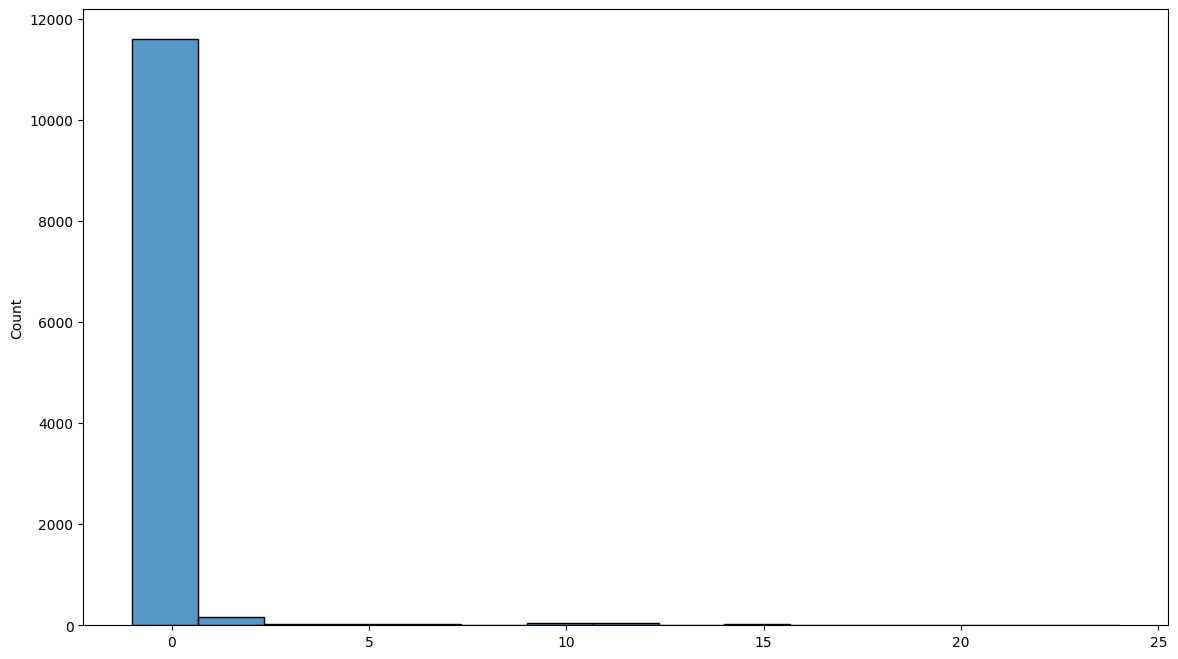

In [61]:
plt.figure(figsize=(14,8)).clf()
sns.histplot(clustering.labels_)

In [62]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters =  true_k, random_state = 0)
km.fit(X)
labels = km.labels_

/Users/mat/opt/anaconda3/envs/asseco/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: ylabel='Count'>

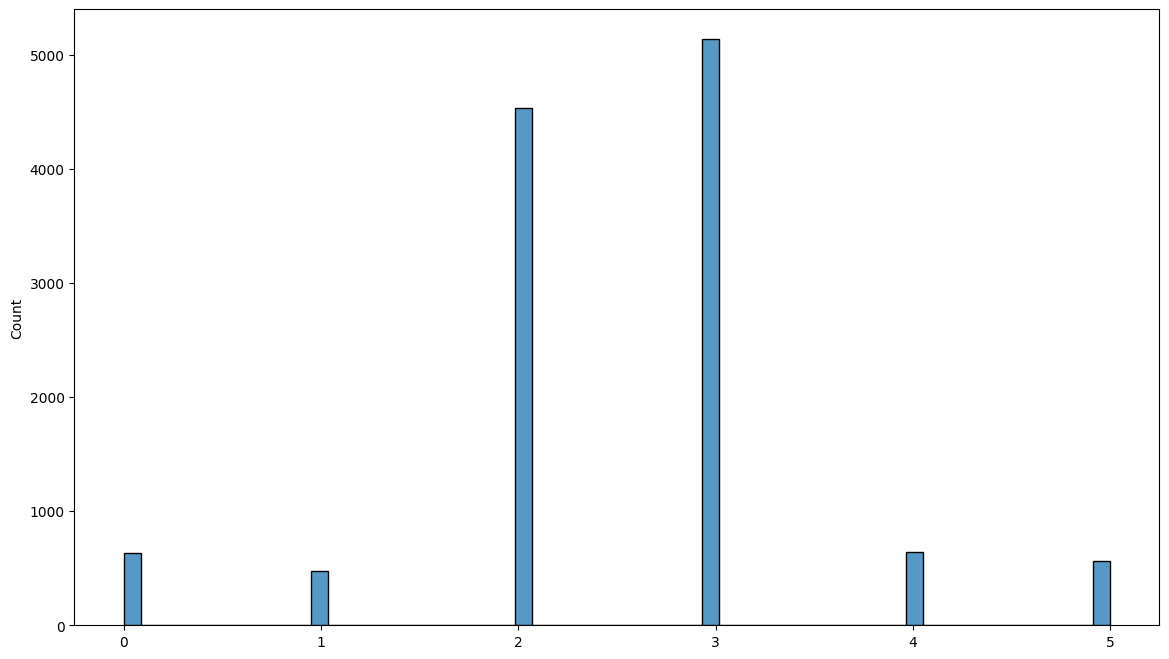

In [63]:
plt.figure(figsize=(14,8)).clf()
sns.histplot(labels)

## Najważniejsze słowa wokół których są środki klastrów umiejscowione. Metaforycznie bo to nadal kilkaset wymiarów

In [64]:
centroids = km.cluster_centers_.argsort()[:, ::-1] ## Indices of largest centroids' entries in descending order
terms = vectorizer.get_feature_names_out()
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: window file run program problem help set softwar card chang
Cluster 1: car engin drive buy year price problem right power got
Cluster 2: god right year believ govern said mean point state mani
Cluster 3: mail pleas com post comput program univers problem help email
Cluster 4: drive card hard control problem pleas comput softwar bit set
Cluster 5: game play year run start realli let great come best


In [65]:
# A w praktyce wygląda to tak:
def count_clustering_scores(X, cluster_num, model, score_fun):
    # Napiszmy tę funkcje tak ogólnie, jak to możliwe. 
    # Zwróćcie uwagę na przekazanie obiektów typu callable: model i score_fun.
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

/Users/mat/opt/anaconda3/envs/asseco/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mat/opt/anaconda3/envs/asseco/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mat/opt/anaconda3/envs/asseco/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mat/opt/anaconda3/envs/asseco/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to su

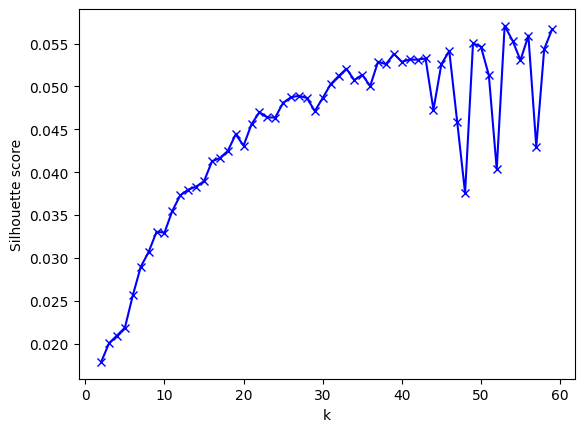

In [66]:
cluster_num_seq = range(2, 60) # Niektóre metryki nie działają gdy mamy tylko jeden klaster
silhouette_vec = count_clustering_scores(X, cluster_num_seq, KMeans, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

In [67]:
def count_wcss_scores(X, k_max):
    #  WCSS = within-cluster sum of squares
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1 # score returns -WCSS
        scores.append(wcss)
    return scores

/Users/mat/opt/anaconda3/envs/asseco/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mat/opt/anaconda3/envs/asseco/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mat/opt/anaconda3/envs/asseco/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mat/opt/anaconda3/envs/asseco/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to su

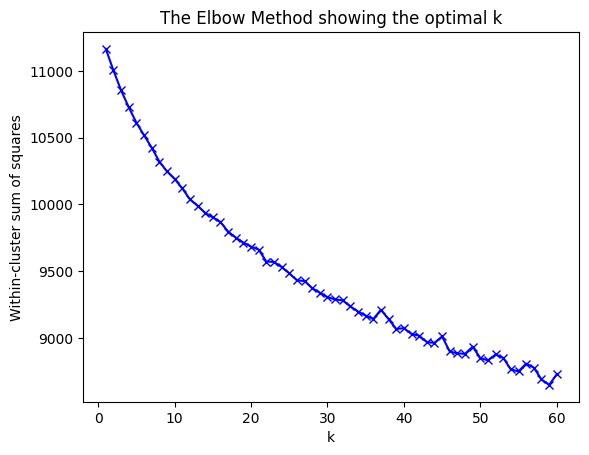

In [68]:
wcss_vec = count_wcss_scores(X, 60)
x_ticks = list(range(1, len(wcss_vec) + 1))
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()